In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from numpy import where
import pandas as pd
import re
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

# Setup

In [10]:
df = pd.read_csv("/home/jupyter/fake_job_postings.csv",index_col='job_id')

Because we've identified the False Negative to be the errors with the highest cost and because we'd rather use a ROC_AUC score (as well as the ROC curve which has the benefit to help us fine tune the most efficient model), we've decided to swap the values in the 'fraudulent' column. This means the model will now predict if a job post is legitimate and it will allow us to minimise the False positive (when an offer is flagged as legit by the model but actually is of fraudulent nature):

In [11]:
df['fraudulent'].replace([0,1], [1,0], inplace=True)

## Addressing the missing information

We have decided to address the missing information in the different columns by replacing the lack of information by `NA`. Instead of using the 'Other' or 'Unspecified' values available in certain columns, this will allow us to quickly spot when the information was not provided:

01. title:               No missing data
02. location:            NA
03. department:          NA
04. salary_range:        NA
05. company_profile:     NA
06. description:         NA
07. requirements:        NA
08. benefits:            NA
09. telecommuting:       No missing data
10. has_company_logo:    No missing data
11. has_questions:       No missing data
12. employment_type:     NA
13. required_experience: NA
14. required_education:  NA
15. industry:            NA
16. function:            NA
17. fraudulent:          No missing data

In [12]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)

 Some job offers have contact details or external url. Could this be linked to fraudulent activity? Could this improve our model's performance?

In [13]:
# turn into a function: use dict (columnName:textToSearch, list(dictinput.keys())[0]:list(dictinput.values())[0])
df = df.assign(hasEMAIL=0, hasPHONE=0, hasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['hasURL'][i] = 1
        elif df[column][i].find('#PHONE_')!=-1:
            df['hasPHONE'][i] = 1
        elif df[column][i].find('#EMAIL_')!=-1:
            df['hasEMAIL'][i] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Some job offers have been written in other alphabets, such as russian or greek. But because those job offers were flagged as legitimate and because we wouldn't be able to understand those offers fully (not speaking the language), we are going to remove them from our dataset:

## Text cleaning and pre-processing

In [14]:
df.columns[4:8]

Index(['company_profile', 'description', 'requirements', 'benefits'], dtype='object')

In [15]:
index_non_latin = []
for column in df.columns[4:8]:
        index_non_latin.append(df[df[column].str.find('α')!=-1].index)
        index_non_latin.append(df[df[column].str.find('и')!=-1].index)
        index_non_latin.append(df[df[column].str.find('แ')!=-1].index)
        index_non_latin.append(df[df['location'].str.find('HK')!=-1].index)
        index_non_latin.append(df[df['location'].str.find('KR')!=-1].index)

In [16]:
for i in range(1,len(index_non_latin)):
    index_non_latin[0] = index_non_latin[0].append(index_non_latin[i])

In [17]:
index_non_latin = sorted(set(list(index_non_latin[0])))

In [18]:
df[df.index.isin(index_non_latin)]['fraudulent'].value_counts()

1    167
Name: fraudulent, dtype: int64

In [19]:
df = df[df.index.isin(index_non_latin)==False]
df.reset_index(inplace=True)
len(df)

17713

In [21]:
for column in df.columns[5:9]:
    df[column].replace('([A-Z][a-z]|[A-Z] )', r' \1', regex=True, inplace=True)
    df[column].replace('(#URL\w+|#PHONE\w+|#EMAIL\w+)', ' ', regex=True, inplace=True)
    df[column].replace('(\\W|\\d)', ' ', regex=True, inplace=True)
    df[column].replace('\ +', ' ', regex=True, inplace=True)

In [49]:
re.search('[a-zA-Z]/{1,3}', 'The lazy for is qwroijflds')

In [22]:
df[df['location'].str.find('TW, TPQ,')!=-1]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,hasEMAIL,hasPHONE,hasURL
4773,4833,Senior Engineering Product Manager,"TW, TPQ, Taipei",Engineering,NA,Aptitude Staffing Solutions has redesigned th...,Senior Engineering Product Manager Taiwan Taipei,NA,What Is Offered Very competitive base salary ...,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Telecommunications,Engineering,0,0,1,0
9388,9488,"Business Development Manager, Taiwan","TW, TPQ,",NA,NA,Our mission is to optimize the first screen o...,Buzzvil is looking for a Business Development...,As our Business Development Manager Taiwan yo...,NA,0,...,1,Full-time,Not Applicable,NA,Information Technology and Services,Business Development,1,0,0,0
11658,11770,Product Development Engineer PLC,"TW, TPQ, Taipei",Engineering,120000-180000,Aptitude Staffing Solutions has redesigned th...,Product Development Engineer PL C Taiwan Work...,Skills and Requirements At least years PL C h...,What Is Offered Very competitive base salary ...,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Computer Networking,Engineering,0,0,1,0
11987,12101,"Operations Manager, Taiwan","TW, TPQ,",Operations,NA,Our mission is to optimize the first screen o...,Buzzvil is looking for an Operations Manager ...,As our Operations Manager Taiwan you should h...,NA,0,...,1,Full-time,Not Applicable,NA,Information Technology and Services,Marketing,1,0,0,0


In [23]:
df[df['job_id'] == 5990]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,hasEMAIL,hasPHONE,hasURL
5921,5990,"Business Development Manager, Japan","JP, 13,",NA,NA,Our mission is to optimize the first screen o...,Buzzvil is looking for a sales business devel...,As our Business Development Manager Japan you...,NA,0,...,1,Full-time,Not Applicable,NA,Information Technology and Services,Business Development,1,0,0,0


In [24]:
for column in df.columns[5:9]:
    for i in range(1, len(df[column])):
#         df[column].str.encode('utf8')
        if re.search(r'[^\x00-\x7F]+',df[column][i])!= None:
            print(re.search(r'[^\x00-\x7F]+',df[column][i]), df['job_id'][i])

<re.Match object; span=(832, 833), match='é'> 58
<re.Match object; span=(287, 288), match='é'> 194
<re.Match object; span=(260, 261), match='ﬂ'> 234
<re.Match object; span=(354, 355), match='é'> 337
<re.Match object; span=(4, 5), match='Á'> 557
<re.Match object; span=(541, 542), match='é'> 600
<re.Match object; span=(653, 654), match='é'> 897
<re.Match object; span=(653, 654), match='é'> 899
<re.Match object; span=(653, 654), match='é'> 903
<re.Match object; span=(88, 89), match='í'> 986
<re.Match object; span=(1419, 1422), match='ΜΗΤ'> 1017
<re.Match object; span=(832, 833), match='é'> 1313
<re.Match object; span=(543, 544), match='Μ'> 1632
<re.Match object; span=(651, 652), match='é'> 1721
<re.Match object; span=(832, 833), match='é'> 1810
<re.Match object; span=(4, 5), match='é'> 1859
<re.Match object; span=(832, 833), match='é'> 1986
<re.Match object; span=(543, 544), match='Μ'> 2040
<re.Match object; span=(714, 715), match='ö'> 2050
<re.Match object; span=(714, 715), match='ö'> 20

Let's see if any clear pattern can already be identified:

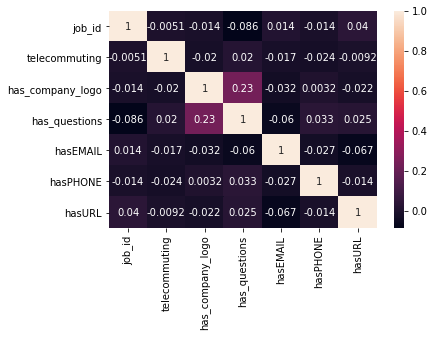

In [25]:
sns.heatmap(df.drop(columns=['fraudulent']).corr(), annot=True);

No multicollinearity issues with those binary variables

# Information loss

Some information is too complex to deal with (e.g. `'title'` has 11,231 unique values over the 17,790 job offers in this dataset), or has too much missing values (`'salary_range'` has 14,925 missing values over the 17,790 in this dataset), either ways they would marginally improve the results of our analysis so we are going to remove those columns from our dataset.

In [26]:
df.drop(columns=['job_id','title', 'location', 'department', 'salary_range'], inplace=True)

# Train Test Split

In [27]:
labels = df['fraudulent']
features = df.drop(columns=['fraudulent'])

In [28]:
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                    labels,
                                                    random_state=666)

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=666,
              shuffle=True
             )

# Dataset formatting

## Numerise the categorical data

In [29]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [30]:
cat_features = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
features_train_cat = features_train.loc[:, cat_features]
features_test_cat = features_test.loc[:, cat_features]

In [31]:
features_train_ohe = ohe.fit_transform(features_train_cat)
features_test_ohe = ohe.transform(features_test_cat)

In [32]:
cat_train_df = pd.DataFrame(features_train_ohe, columns=ohe.get_feature_names(input_features=cat_features))
cat_test_df = pd.DataFrame(features_test_ohe, columns=ohe.get_feature_names(input_features=cat_features))

## TF-IDF computation on the text data

In [33]:
vect_comp = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000)
vect_desc = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000)
vect_req = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000)
vect_ben = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000)

In [34]:
text_features = ['company_profile', 'description', 'requirements', 'benefits']
features_train_text = features_train.loc[:, text_features]
features_test_text = features_test.loc[:, text_features]

In [35]:
# train
features_train_vectorized_c = vect_comp.fit_transform(features_train_text['company_profile'])
features_train_vectorized_d = vect_desc.fit_transform(features_train_text['description'])
features_train_vectorized_r = vect_req.fit_transform(features_train_text['requirements'])
features_train_vectorized_b = vect_ben.fit_transform(features_train_text['benefits'])
# test
features_test_vectorized_c = vect_comp.transform(features_test_text['company_profile'])
features_test_vectorized_d = vect_desc.transform(features_test_text['description'])
features_test_vectorized_r = vect_req.transform(features_test_text['requirements'])
features_test_vectorized_b = vect_ben.transform(features_test_text['benefits'])

In [39]:
Counter(vect_req.vocabulary_).most_common(200)

[('ω', 4999),
 ('zoom', 4998),
 ('zones', 4997),
 ('zone', 4996),
 ('zendesk', 4995),
 ('zend', 4994),
 ('zealand', 4993),
 ('ze', 4992),
 ('z', 4991),
 ('yum', 4990),
 ('yrs', 4989),
 ('yr', 4988),
 ('youth', 4987),
 ('young', 4986),
 ('york', 4985),
 ('yo', 4984),
 ('yii', 4983),
 ('yes', 4982),
 ('years', 4981),
 ('year', 4980),
 ('yahoo', 4979),
 ('y', 4978),
 ('xslt', 4977),
 ('xsl', 4976),
 ('xp', 4975),
 ('xml', 4974),
 ('xm', 4973),
 ('xhtml', 4972),
 ('xero', 4971),
 ('xen', 4970),
 ('xcode', 4969),
 ('x', 4968),
 ('ws', 4967),
 ('written', 4966),
 ('writing', 4965),
 ('writes', 4964),
 ('writers', 4963),
 ('writer', 4962),
 ('write', 4961),
 ('wrenches', 4960),
 ('wpm', 4959),
 ('wp', 4958),
 ('wow', 4957),
 ('worth', 4956),
 ('worry', 4955),
 ('worldwide', 4954),
 ('world', 4953),
 ('workshops', 4952),
 ('workshop', 4951),
 ('works', 4950),
 ('workplace', 4949),
 ('workload', 4948),
 ('working', 4947),
 ('workforce', 4946),
 ('workflows', 4945),
 ('workflow', 4944),
 ('worke

In [ ]:
ftrainvc_df = pd.DataFrame(features_train_vectorized_c.todense(), columns=vect_comp.get_feature_names())
ftrainvd_df = pd.DataFrame(features_train_vectorized_d.todense(), columns=vect_desc.get_feature_names())
ftrainvr_df = pd.DataFrame(features_train_vectorized_r.todense(), columns=vect_req.get_feature_names())
ftrainvb_df = pd.DataFrame(features_train_vectorized_b.todense(), columns=vect_ben.get_feature_names())
text_train_df = pd.concat([ftrainvc_df, ftrainvd_df, ftrainvr_df, ftrainvb_df], axis=1)
ftestvc_df = pd.DataFrame(features_test_vectorized_c.todense(), columns=vect_comp.get_feature_names())
ftestvd_df = pd.DataFrame(features_test_vectorized_d.todense(), columns=vect_desc.get_feature_names())
ftestvr_df = pd.DataFrame(features_test_vectorized_r.todense(), columns=vect_req.get_feature_names())
ftestvb_df = pd.DataFrame(features_test_vectorized_b.todense(), columns=vect_ben.get_feature_names())
text_test_df = pd.concat([ftestvc_df, ftestvd_df, ftestvr_df, ftestvb_df], axis=1)

In [ ]:
del ftrainvb_df
del ftrainvc_df
del ftrainvd_df
del ftrainvr_df
del ftestvb_df
del ftestvc_df
del ftestvd_df
del ftestvr_df

## Binary data

In [ ]:
binary_features = ['telecommuting', 'has_company_logo', 'has_questions', 'hasURL', 'hasPHONE', 'hasEMAIL']
binary_train_df = features_train.loc[:, binary_features]
binary_test_df = features_test.loc[:, binary_features]
binary_train_df.reset_index(inplace=True)
binary_test_df.reset_index(inplace=True)

## Merging the dataframes

In [ ]:
feat_train = pd.concat([cat_train_df, text_train_df, binary_train_df], axis=1)
feat_test = pd.concat([cat_test_df, text_test_df, binary_test_df], axis=1)

# Addressing the class imbalance

As class imbalance will only matter during the training step, SMOTE will only be applied to to train dataset.

In [ ]:
# SMOTE doesn't work on text, it needs to be changed to TF-IDF
sm = SMOTE(random_state=666, n_jobs=4)

In [ ]:
X, y = sm.fit_resample(feat_train.values, labels_train)

## Shape check

# Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()

In [ ]:
gnb.fit(X, y)

In [ ]:
labels_train_pred = gnb.predict_proba(X)

In [ ]:
fpr, tpr, thresholds = roc_curve(y, labels_train_pred[:,1])
print('AUC train dataset: {}'.format(auc(fpr, tpr)))

# Multinomial Naive Bayes

In [ ]:
mnb = MultinomialNB(alpha=0.01)

In [ ]:
mnb.fit(X, y)

In [ ]:
labels_train_pred = mnb.predict_proba(X)

In [ ]:
fpr, tpr, thresholds = roc_curve(y, labels_train_pred[:,1])
print('AUC train dataset: {}'.format(auc(fpr, tpr)))
# with alpha = 1: AUC = 0.9908159833756562

# Random Forest

In [ ]:
# rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=666)

In [ ]:
# rfc.fit(X, y)

In [ ]:
# features = feat_train.columns
# importances = rfc.feature_importances_
# indices = np.argsort(importances)

# plt.barh(range(len(indices)),importances[indices], align='center');
# plt.yticks(range(len(indices)), [features[i] for i in indices]);

In [ ]:
# labels_train_pred = rfc.predict(X)

In [ ]:
# fpr, tpr, thresholds = roc_curve(y, labels_train_pred)
# print('AUC train dataset: {}'.format(auc(fpr, tpr)))

## XGBoost

In [ ]:
# xgb = XGBClassifier()

In [ ]:
# xgb.fit(X, y)

In [ ]:
# labels_train_pred = xgb.predict(X)

In [ ]:
# fpr, tpr, thresholds = roc_curve(y, labels_train_pred)
# print('AUC train dataset: {}'.format(auc(fpr, tpr)))

# Finalising the selected model: Multinomial Bayesian Model

## Confusion matrix

In [ ]:
labels_hat_test = mnb.predict(feat_test)

cnf_matrix = confusion_matrix(labels_test, labels_hat_test)

# Create the basic matrix
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(labels) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

In [ ]:
cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
def conf_matrix(self,labels_test, labels_hat_test):
        for ind, label in enumerate(labels_test):
            pred = labels_hat_test[ind]
            if label == 1: 
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
            self.cm_values = cm
        return cm

In [ ]:
conf_matrix(mnb,labels_test,labels_hat_test)
# Multinomial Naybe Bayes
# alpha=1 : {'TP': 3982, 'TN': 174, 'FP': 17, 'FN': 275}
# alpha=0.01 : {'TP': 4129, 'TN': 154, 'FP': 37, 'FN': 128}
# XGBoost {'TP': 4254, 'TN': 156, 'FP': 35, 'FN': 3}

## Receiver Operating Characteristic

In [ ]:
def buildROC(target_train, train_preds, target_test,test_preds):
    fpr, tpr, threshold = roc_curve(target_test, test_preds)
    roc_auc = auc(fpr, tpr)
    fpr1, tpr1, threshold = roc_curve(target_train, train_preds)
    roc_auc1 = auc(fpr1, tpr1)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr1, tpr1, 'b', label = 'Train AUC = %0.2f' % roc_auc1)
    plt.plot(fpr, tpr, 'b', label = 'Validation AUC = %0.2f' % roc_auc, color = 'g')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.gcf().savefig('roc.png')

In [ ]:
training_preds = mnb.predict_proba(feat_train.values)
test_preds = mnb.predict_proba(feat_test.values)

training_roc_auc = roc_auc_score(labels_train, training_preds[:,1])
test_roc_auc = roc_auc_score(labels_test, test_preds[:,1])

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Test ROC_AUC: {:.4}%'.format(test_roc_auc * 100))

# Multinomial Bayes
# Training ROC_AUC: 99.51%
# Test ROC_AUC: 98.42%

# XGBoost
# Training ROC_AUC: 100.0%
# Test ROC_AUC: 98.94%

### ROC plot

In [ ]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %75 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

In [ ]:
plt.figure(figsize=(15,15))
for data in [[labels_train, training_preds[:,1]],[labels_test, test_preds[:,1]]]:
    fpr, tpr, threshold = roc_curve(data[0], data[1])
    plt.plot(fpr, tpr)
annot(fpr, tpr, threshold)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.ylabel('TPR (power)')
plt.xlabel('FPR (alpha)')
plt.legend(['train','test'])
plt.show()

### Threshold selection

## Cost Function

In [ ]:
#The cost function terms are wrong, double check those!

# Focusing on a stat that improves your game
cTP = 100
# Not focusing on a stat that doesn't improve your game
cTN = 1
# Focusing on a stat that doesn't improve your game
cFP = 100
# Not focusing on a stat that improves your game
cFN = 20

prevalence = (cm['TP']+cm['FN']) / (cm['TP']+cm['FP']+cm['TN']+cm['FN'])

# Metz coefficient
_m = ((1-prevalence)/prevalence) * ((cFP-cTN) / (cFN-cTP))

# Using the Zweig & Campbell equation:
function_m = cm['TP'] -_m*cm['FP']
function_m

# Model optimisation

In [ ]:
# pipeline = Pipeline(([TfidfVectorizer()),
#                       (multinomialNB())
# ])

In [ ]:
np.arange(0.05, 0.21, 0.05)

In [ ]:
param_grid = {'alpha': [x for x in np.arange(0.01, 0.21, 0.05)],
#               'fit_prior': [True, False],
#               'ngram_range': [(1,1), (1,2), (1,3), (1,4)]
#               'max_features': 
             }

# GSCV round 1: 'alpha': [0.1, 1, 3, 6, 10, 20, 50] // roc_auc: 0.9945829757065059
# GCSV round 2: 'alpha': [x for x in np.arange(0.01, 0.21, 0.05)] // roc_auc: 0.9963658600529754

In [ ]:
grid = GridSearchCV(estimator = mnb, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [ ]:
grid = grid.fit(X, y)

In [ ]:
print(grid.best_score_, grid.best_params_)

# Pipeline

In [ ]:
pipe = Pipeline([('vect_comp' = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000),
                  ('vect_desc', TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000),
                   ('vect_req', TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000),
                    ('vect_ben', TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000),
                     ('mnb', MultinomialNB(alpha=0.01))
                     ]
                    )

In [ ]:
pipe.fit(X, y)

In [ ]:
param_grid = {'mnb__alpha': [x for x in np.arange(0.01, 0.21, 0.05)],
              'mnb__fit_prior': [True, False],
              'ngram_range': [(1,1), (1,2), (1,3), (1,4)]
              'max_features': [x for x in range (0, 30000, 5000)]
             }